# Atencja oparta o iloczyn skalarny i architektura Transformer

##Atencja oparta o iloczyn skalarny

**Atencja oparta o iloczyn skalarny** (*dot-product attention*) jest mechanizmem atencji stosowanym w architekturze Transformer.
Mechanizm atencji pozwala przekształcić każdy wektor reprezentacji (osadzenie) biorąc pod uwagę szerszy kontekst, czyli wszystkie pozostałe wektory w sekwencji.
W przypadku **auto-atencji** (*auto-attention*) brane są pod uwagę wektory w tej samej sekwencji. W przypadku **atencji krzyżowej** (*cross-attention*) kontekst stanowi inna sekwencja.
W zastosowaniach związanych z przetwarzaniem tekstów w języku naturalnym umożliwia to tworzenie kontekstowych reprezentacji słów/tokenów biorących pod uwagę kontekst w jakim występują.

Załóżmy, że mamy sekwencję $n$ wektorów, na przykład wektorowych reprezentacji słów/tokenów, $x_1, \ldots, x_n$, gdzie $x_i \in \mathbb{R}^{d}$.

**W mechanizmie auto-atencji opartej o iloczyn skalarny** dla każdego wektora $x_i$ wyznaczane są wartości:
*   **zapytania** $q_i = x_i W_q$
*   **klucza** $k_i = x_i W_k$
*   **wartości** $v_i = x_i W_v$

$W_q, W_k, W_v \in \mathbb{R}^{d \times d}$ są macierzami projekcji. Macierze projekcji są parametrami (wagami) warstwy atencji - są inicjalizowane losowo i optymalizowane w procesie uczenia modelu.

Wyznaczanie zapytania, klucza i wartości dla każdego elementu sekwencji możemy zapisać w formie macierzowej.
Niech $X \in \mathbb{R}^{n \times d}$ będzie macierzą złożoną z wejściowych wektorów:
$$
X = \left(
\begin{align}
x_1 \\
\vdots \\
x_n \\
\end{align}
\right)
$$
**Wówczas macierze złożone z wektorów zapytań, kluczy i wartości** wyznaczamy jako:
$$
Q = X W_q \\
K = X W_k \\
V = X W_v
$$

**Atencja oparta o iloczyn skalarny** zdefiniowana jest wzorem:
$$
\textrm{Attention}(Q, K, V) = \textrm{softmax} \left( \frac{QK^T}{\sqrt d} \right) V
$$
Wynik $\textrm{Attention}(Q, K, V)$ jest macierzą identycznego rozmiaru jak wejściowa macierz $X$ i zawiera zaktualizowane wartości wektorów z wejściowej sekwencji z uwzględnieniem kontekstu (wartości wszystkich pozostałych wektorów w sekwencji).

Wyznaczanie wyniku atencji składa się następujących kroków:
*  Krok 1: Wyznaczenie **współczynników atencji** (*attention scores*) mierzących podobieństwo między wektorami zapytań ($Q$) i kluczy ($K$) jako skalowanego iloczynu skalarnego $\frac{QK^T}{\sqrt d_k}$. Współczynnik skalujący $\frac{1}{\sqrt d_k}$ ogranicza wartości będące argumentami funkcji softmax. $d$ oznacza rozmiar wektora klucza czyli liczbę kolumn macierzy $K$.
*  Krok 2: Zastosowanie funkcji softmax aby wyznaczyć macierz **wag atencji** której wiersze sumują się do jedności.
*  Krok 3: Wyznaczenie wynikowych wartości, jako sum wektorów wartości ($V$) ważonych wagami atencji.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

In [2]:
torch.manual_seed(44)

seq_length = 4
d = 6

# Utwórz losowy tensor wejściowy zawierający sekwencję seq_length=4 złożoną z wektorów rozmiaru d=6
print("Macierz X")
X = torch.rand(seq_length, d)
print(X)
print(f"{X.shape=}\n")

# Do celów poglądowych utworzymy losowe macierze projekcji W_q, W_k, W_v zainicjalizowne rozkładem normalnym
W_q = torch.randn(d, d)
W_k = torch.randn(d, d)
W_v = torch.randn(d, d)

# Wyznacz macierze Q, K, V
Q = torch.matmul(X, W_q)
K = torch.matmul(X, W_k)
V = torch.matmul(X, W_v)

print(f"{Q.shape=}")
print(f"{K.shape=}")
print(f"{V.shape=}")

Macierz X
tensor([[0.7196, 0.7307, 0.8278, 0.1343, 0.6280, 0.7297],
        [0.2882, 0.2112, 0.9836, 0.8722, 0.9650, 0.7837],
        [0.8076, 0.0608, 0.7226, 0.3354, 0.5350, 0.7117],
        [0.7979, 0.2785, 0.8947, 0.6694, 0.8950, 0.4479]])
X.shape=torch.Size([4, 6])

Q.shape=torch.Size([4, 6])
K.shape=torch.Size([4, 6])
V.shape=torch.Size([4, 6])


**Krok 1:** Wyznacz współczynniki atencji

In [3]:
d = Q.size(-1)
att_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d))

In [4]:
print(f"Współczynniki atencji")
print(att_scores)

print(f"Suma elementów w wierszach: {att_scores.sum(dim=-1)}")
print(f"{att_scores.shape=}")

# Sprawdzenie poprawności wyznaczenia współczynników atencji
assert att_scores.shape == (seq_length, seq_length)
assert torch.isclose(att_scores[0,0], torch.tensor(2.1263), atol=1e-04)
assert torch.isclose(att_scores[1,2], torch.tensor(1.1623), atol=1e-04)

Współczynniki atencji
tensor([[2.1263, 0.5719, 1.6323, 1.6140],
        [2.4103, 1.3636, 1.1623, 1.1908],
        [2.0439, 1.3665, 1.5372, 1.7057],
        [3.7581, 3.2859, 2.9801, 3.2318]])
Suma elementów w wierszach: tensor([ 5.9446,  6.1270,  6.6532, 13.2559])
att_scores.shape=torch.Size([4, 4])


**Krok 2**: Zastosuj softmax aby wyznaczyć macierz wag atencji której wiersze sumują się do jedności.

In [5]:
att_weights = F.softmax(att_scores, dim=-1)

In [6]:
print(f"Wagi atencji")
print(att_weights)

print(f"Suma elementów w wierszach: {att_weights.sum(dim=-1)}")
print(f"{att_weights.shape=}")

# Sprawdzenie poprawności wyznaczenia współczynników atencji
assert att_weights.shape == (seq_length, seq_length)
assert torch.allclose(att_weights.sum(dim=-1), torch.ones_like(att_weights.sum(dim=-1)))

Wagi atencji
tensor([[0.4131, 0.0873, 0.2521, 0.2475],
        [0.5172, 0.1816, 0.1485, 0.1528],
        [0.3542, 0.1799, 0.2134, 0.2525],
        [0.3740, 0.2333, 0.1718, 0.2210]])
Suma elementów w wierszach: tensor([1.0000, 1.0000, 1.0000, 1.0000])
att_weights.shape=torch.Size([4, 4])


**Krok 3**:

Wyznaczenie wynikowych wartości, jako sum wektorów wartości (V) ważonych wagami atencji.

In [7]:
Z = torch.matmul(att_weights, V)

In [8]:
print(f"Wejściowa macierz X")
print(X)
print(f"\nMacierz wartości V")
print(V)
print(f"\nWynikowa macierz Z")
print(Z)

# Sprawdzenie poprawności wyznaczenia współczynników atencji
assert Z.shape == X.shape
assert torch.isclose(Z[0,0], torch.tensor(0.1211), atol=1e-04)
assert torch.isclose(Z[1,2], torch.tensor(1.5165), atol=1e-04)

Wejściowa macierz X
tensor([[0.7196, 0.7307, 0.8278, 0.1343, 0.6280, 0.7297],
        [0.2882, 0.2112, 0.9836, 0.8722, 0.9650, 0.7837],
        [0.8076, 0.0608, 0.7226, 0.3354, 0.5350, 0.7117],
        [0.7979, 0.2785, 0.8947, 0.6694, 0.8950, 0.4479]])

Macierz wartości V
tensor([[ 0.4475,  0.9592,  1.1433,  0.8931, -3.1082,  0.6802],
        [-0.4231, -0.0483,  2.0343, -0.4982, -4.3946,  0.3621],
        [ 0.1516,  0.0811,  1.7753, -0.4668, -3.7134,  0.0351],
        [-0.2628,  0.2503,  1.9130,  0.3841, -4.2430,  0.0205]])

Wynikowa macierz Z
tensor([[ 0.1211,  0.4744,  1.5709,  0.3028, -3.6539,  0.3266],
        [ 0.1370,  0.5376,  1.5165,  0.3608, -3.6050,  0.4259],
        [ 0.0484,  0.4115,  1.6329,  0.2241, -3.7554,  0.3187],
        [ 0.0367,  0.4167,  1.6298,  0.2225, -3.7630,  0.3494]])


Połącz napisane wcześniej fragmenty kodu w jedną funkcję `dot_product_attention` wyznaczającą wartości atencji opartej o iloczyn skalarny.
*   Na wejściu funkcja otrzyma zapytania, klucze i wartości jako tensory `Q`, `K`, `V`
*   Zwróci parę tensorów: wynikową wartość oraz wagi atencji

**Uwaga**: Funkcja powinna operować zarówno na dwuwymiarowych tensorach (macierzach) `(seq_len, d)` oraz trójwymiarowych tensorach zawierających jako pierwszy wymiar wsadu `(batch_size, seq_len, d)`. Aby funkcja poprawnie działała na macierzach o trzech wymiarach, wykorzystaj metodę `transpose` do transpozycji dwóch ostatnich wymiarów tensora `K`.

In [9]:
def dot_product_attention(Q: Tensor, K: Tensor, V: Tensor) -> tuple[Tensor, Tensor]:
    d = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d, dtype=torch.float32)) # Wyjasnione niżej jak działa
    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, V)
    return output, attention_weights

In [10]:
# JAK DZIAŁA .transpose
torch.manual_seed(44)
x = torch.randn(2, 3)
print(x)
print(100 * '-')
x = x.transpose(-1, -2)
print(x)

# wskazujemy (x1, x2)
# x1 - wymiar który mamy transponować
# x2 - na jaką wielkość mamy transponować x2

tensor([[ 0.0589, -1.3945,  0.8448],
        [ 0.1268,  1.0822, -1.1731]])
----------------------------------------------------------------------------------------------------
tensor([[ 0.0589,  0.1268],
        [-1.3945,  1.0822],
        [ 0.8448, -1.1731]])


In [11]:
# Spradzenie działania funkcji dot_product_attention

batch_size = 2
seq_length = 4
d = 6

# Sprawdzenie działania dla dwuywymiarowego tensora
X = torch.rand(seq_length, d)
Q = torch.matmul(X, W_q)
K = torch.matmul(X, W_k)
V = torch.matmul(X, W_v)

output, attention_weights = dot_product_attention(Q, K, V)
print(f"{output.shape=}")
print(f"{attention_weights.shape=}")

assert output.shape == X.shape
assert attention_weights.shape == (seq_length, seq_length)

output.shape=torch.Size([4, 6])
attention_weights.shape=torch.Size([4, 4])


--------------------------------------------------------------------------------
Wyjaśnienie wzoru:
$$(\frac{QK^T}{\sqrt d})$$

In [12]:
print(f"{Q.shape= }")
print(f"{K.shape= }")
x1 = torch.matmul(Q, K.transpose(-2, -1))
print(f"{x1.shape= }")
print(f"{torch.tensor(d, dtype=torch.float32)= }")
x2 = x1 / torch.sqrt(torch.tensor(d, dtype=torch.float32)) # ARGUMENT .sqrt() musi być tensorem ,dlatego wymiar d robimy na tensor
print(f"{x2=}")

Q.shape= torch.Size([4, 6])
K.shape= torch.Size([4, 6])
x1.shape= torch.Size([4, 4])
torch.tensor(d, dtype=torch.float32)= tensor(6.)
x2=tensor([[1.5372, 1.7057, 1.9075, 1.3565],
        [2.9801, 3.2318, 2.9555, 2.3137],
        [0.5592, 0.5684, 1.9804, 1.5105],
        [1.6358, 1.5519, 1.1831, 1.0905]])


--------------------------------------------------------------------------------

In [13]:
# Sprawdzenie działania dla trójwymiarowego tensora
X = torch.rand(batch_size, seq_length, d)
Q = torch.matmul(X, W_q)
K = torch.matmul(X, W_k)
V = torch.matmul(X, W_v)

output, attention_weights = dot_product_attention(Q, K, V)
print(f"{output.shape=}")
print(f"{attention_weights.shape=}")

assert output.shape == X.shape
assert attention_weights.shape == (batch_size, seq_length, seq_length)

output.shape=torch.Size([2, 4, 6])
attention_weights.shape=torch.Size([2, 4, 4])


##Implementacja uproszczonej architektury dwukierunkowego Transformera

W dalszej części notatnika zaimplementujemy uproszczoną architekturę dwukierunkowego Transformera i zastosujemy do zadania klasyfikacji elementów wejściowej sekwencji.

**Dwukierunkowy Transformer**, inaczej **tylko-koder**, wyznaczając wartość atencji dla elementu sekwencji bierze pod uwagę wszystkie elementy z sekwencji, zarówne te poprzedzające jak i następujące później. Jest stosowany w modelach językowych klasy tylko-koder, takich jak BERT.
W odróżnieniu od pełnej architektury Transformera nasz model będzie wykorzystywał tylko jedną głowicę atencji.

**Jednokierunkowy Transformer**, inaczej **tylko-dekoder**,
wyznaczając wartość atencji dla elemetu sekwencji bierze pod uwagę tylko elementy występujące nie później w sekwencji.
Podczas wyznaczania wartości atencji stosowana jest maska atencji przyczynowej (*causal attention mask*), która dla każdego elementu w sekwencji maskuje dostęp do elementów po nim następujących.
Są stosowane w generatywnych modelach językowych takich, jak GPT.


Klasa `SingleHeadAttention` implementuje jednogłowicową warstwę auto-atencji bez maskowania.

In [14]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()

        # Macierze projekcji zaimplementujemy jako warstwa liniowa bez wektora obciążenia (bias)
        self.Q_w = nn.Linear(d_model, d_model, bias=False) # Query
        self.K_w = nn.Linear(d_model, d_model, bias=False) # Key
        self.V_w = nn.Linear(d_model, d_model, bias=False) # Value

    def forward(self, X: Tensor) -> tuple[Tensor, Tensor]:
        Q = self.Q_w(X)
        K = self.K_w(X)
        V = self.V_w(X)

        values, attention = dot_product_attention(Q, K, V) # Obliczenie wartości atencji
        return values, attention

In [15]:
att = SingleHeadAttention(d_model=d)
print(X)
values, attention = att(X)

print(values.shape)
print(attention.shape)

tensor([[[0.4811, 0.4923, 0.7392, 0.3945, 0.0290, 0.7696],
         [0.6214, 0.0891, 0.4282, 0.0289, 0.7090, 0.3982],
         [0.1633, 0.7222, 0.2019, 0.7982, 0.8446, 0.0180],
         [0.1051, 0.7829, 0.1152, 0.6189, 0.7437, 0.5098]],

        [[0.2611, 0.5224, 0.6299, 0.8890, 0.9520, 0.5174],
         [0.5285, 0.3123, 0.4112, 0.3771, 0.6506, 0.5800],
         [0.0844, 0.6841, 0.6183, 0.4688, 0.0288, 0.9523],
         [0.0781, 0.5020, 0.0405, 0.5495, 0.5620, 0.9785]]])
torch.Size([2, 4, 6])
torch.Size([2, 4, 4])


Implementacja pojedynczej warstwy (pojedycznego bloku) kodera Transformer.

In [16]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model: int, dim_feedforward: int):
        """
        Inputs:
            d_model - Dimensionality of the input
            dim_feedforward - Dimensionality of the hidden layer in the MLP
        """
        super().__init__()

        self.self_attn = SingleHeadAttention(d_model)

        # Klasyczny feedforward network: wartswa liniowa (d -> d_ff) -> RELU -> liniowa (d_ff -> d), wejście -> większy wymiar -> aktywacja ReLU -> powrót do d_model.
        self.linear_net = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, d_model)
        )

        # Warstwy normalizacji
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # Jednogłowicowa warstwa atencji
        attn_out, _ = self.self_attn(x)

        # Połączenie rezydualne, normalizacja nr 1
        x = x + attn_out
        x = self.norm1(x)

        # feedforward part, połączenie rezydualne oraz normalizacja nr 2
        linear_out = self.linear_net(x)
        x = x + linear_out
        x = self.norm2(x)

        return x

In [17]:
encoder = TransformerEncoderLayer(d_model=d, dim_feedforward=2*d)
print(encoder)

TransformerEncoderLayer(
  (self_attn): SingleHeadAttention(
    (Q_w): Linear(in_features=6, out_features=6, bias=False)
    (K_w): Linear(in_features=6, out_features=6, bias=False)
    (V_w): Linear(in_features=6, out_features=6, bias=False)
  )
  (linear_net): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=6, bias=True)
  )
  (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
)


Sprawdzenie działania warstwy kodera Transformer. Na wejściu podajemy tensor o rozmiarach `(batch_size, seq_length, d)` - złożony z `batch_size` sekwencji o `seq_length` elementach/wektorach rozmiaru `d` każdy.
Zauważmy, że na wyjściu otrzymujemy tensor o identycznym kształcie

In [18]:
x = torch.rand(batch_size, seq_length, d)
print(f"{x.shape=}")

y = encoder(x)
print(f"{y.shape=}")

x.shape=torch.Size([2, 4, 6])
y.shape=torch.Size([2, 4, 6])


Implementacja zestawu `num_layers` sekwencyjnie połączonych  warstw kodera Transformer.

In [19]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers: int, d_model: int, dim_feedforward: int):
        super().__init__()
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, dim_feedforward) for _ in range(num_layers)])

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def get_attention_maps(self, x):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

In [20]:
encoder = TransformerEncoder(num_layers=2, d_model=d, dim_feedforward=2048)
print(encoder)

TransformerEncoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): SingleHeadAttention(
        (Q_w): Linear(in_features=6, out_features=6, bias=False)
        (K_w): Linear(in_features=6, out_features=6, bias=False)
        (V_w): Linear(in_features=6, out_features=6, bias=False)
      )
      (linear_net): Sequential(
        (0): Linear(in_features=6, out_features=2048, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=2048, out_features=6, bias=True)
      )
      (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    )
  )
)


In [21]:
x = torch.rand(batch_size, seq_length, d)
print(f"{x.shape=}")

y = encoder(x)
print(f"{y.shape=}")

x.shape=torch.Size([2, 4, 6])
y.shape=torch.Size([2, 4, 6])


Dodatkowe elementy - kodowanie pozycyjne

In [22]:
import math


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [23]:
x = torch.tensor([1, 2, 3, 4])
print(x)
print(x.shape)
print(x.unsqueeze(0))
print(x.unsqueeze(0).shape)

tensor([1, 2, 3, 4])
torch.Size([4])
tensor([[1, 2, 3, 4]])
torch.Size([1, 4])


Kompletna architektura uproszczonego Transformera klasy tylko-koder. Model zostanie wykorzystany do klasyfikacji każdego elementu z sekwencji wejściowej. W tym celu zdefiniujemy głowicę klasyfikacyjną (klasyfikator liniowy) `self.classification = nn.Linear(d_model, num_classes)`. Głowica klasyfikacyjna będzie estymowała rozkład prawdopodobieństwa klas dla każdego wektora w sekwencji wejściowej na podstawie ich kontekstowych reprezentacji.



In [24]:
class MyTransformer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_classes: int, num_layers: int):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer = TransformerEncoder(num_layers, d_model, 2*d_model)
        self.classification = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)

        assert x.dim() == 3
        # Jako reprezentację całej sekwencji bierzemy uśrednione wektory reprezentacji
        # x = x.mean(dim=1)
        x = self.classification(x)
        return x

    def get_attention_maps(self, x):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        with torch.no_grad():
            x = self.embeddings(x)
            x = self.positional_encoding(x)
            attention_maps = self.transformer.get_attention_maps(x)
        return attention_maps

In [25]:
model = MyTransformer(vocab_size=10, d_model=32, num_classes=10, num_layers=1)
print(model)

MyTransformer(
  (embeddings): Embedding(10, 32)
  (positional_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): SingleHeadAttention(
          (Q_w): Linear(in_features=32, out_features=32, bias=False)
          (K_w): Linear(in_features=32, out_features=32, bias=False)
          (V_w): Linear(in_features=32, out_features=32, bias=False)
        )
        (linear_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=32, bias=True)
        )
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (classification): Linear(in_features=32, out_features=10, bias=True)
)


Do wytrenowania modelu wykorzystamy bibliotekę PyTorch Lightning.

In [26]:
!pip install -q lightning
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
import lightning as L
import torchmetrics
import torch.optim as optim


class LitNet(L.LightningModule):
    def __init__(self, classifier: nn.Module):
        super().__init__()
        self.classifier = classifier
        self.criterion = nn.CrossEntropyLoss()

        # TODO: Change hard coded number of classes
        self.metric_train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.metric_val_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.metric_test_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

    def training_step(self, batch, batch_idx):
        # training_step implementuje jeden krok pętli treningowej
        x, target = batch
        logits = self.classifier(x) # logity przed softmaxem

        logits = logits.view(-1, logits.shape[-1]) # spłaszczanie logitów, bo CrossentropyLoss oczekuje logity -> [INDEKSY KLAS, LICZBA KLAS], target -> [INDEKSY KLAS]
        target = target.view(-1)

        loss = self.criterion(logits, target) # obliczanie błędu
        self.log("train/loss", loss, prog_bar=True) # logowanie wartości starty na każdym kroku

        _, preds = torch.max(logits, dim=1) # zwraca maksymalne prawdopodobienstwo z logitów, (wartośc, indeks wartości)
        self.metric_train_acc(preds, target) # aktualizacja metryki
        self.log('train/accuracy', self.metric_train_acc, on_step=False, on_epoch=True, prog_bar=True) # zalogowanie metryki na koniec epoki
        return loss

    def validation_step(self, batch, batch_idx):
        x, target = batch
        logits = self.classifier(x)

        logits = logits.view(-1, logits.shape[-1])
        target = target.view(-1)

        loss = self.criterion(logits, target)
        self.log("val/loss", loss, prog_bar=True)

        _, preds = torch.max(logits, dim=1)
        self.metric_val_acc(preds, target)
        self.log('val/accuracy', self.metric_val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, target = batch
        logits = self.classifier(x)

        logits = logits.view(-1, logits.shape[-1])
        target = target.view(-1)

        _, preds = torch.max(logits, dim=1)
        self.metric_test_acc(preds, target)
        self.log('test/accuracy', self.metric_test_acc, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.classifier.parameters(), lr=1e-4, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=self.trainer.estimated_stepping_batches)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]


Definicja hiper-parametrów procesu uczenia.



In [28]:
vocab_size = 10
d_model = 32
num_classes = vocab_size
num_layers = 1

In [29]:
# Init the network
my_transformer = MyTransformer(vocab_size=vocab_size, d_model=d_model, num_classes=num_classes, num_layers=num_layers)

# Wrap in a lightning module
lit_model = LitNet(my_transformer)

##Zadanie: Odwrócenie kolejności elementów w sekwencji

###Zbiór danych
Wygenerujemy syntetyczny zbiór danych zawierający sekwencje liczb od 0 do 9.
Naszym **zadaniem będzie odwrócenie kolejności liczb w sekwencji wejściowej**.
Potraktujemy to jako problem klasyfikacji każdego elementu sekwencji - chcemy aby model każdemu elementowi sekwencji wejściowej przypisał klasę oczekiwanego na wyjściu elementu.
Na przykład, kolejne elementy sekwencji $1,7,3,4,2$ powinny zostać sklasyfikowane jako odpowiednio $2,4,3,7,1$ - dzięki czemu uzyskamy odwróconą sekwencję.

In [30]:
from torch.utils.data import Dataset, DataLoader


class ReverseDataset(Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len)) # (ilosc klas (0-9), ilosc słów, długosc pojedynczego wektora słowa)
        # print(self.data)
        # print(self.data.shape)

    # Klasa Data set wymaga okreslonej konstrukcji datasetu - tutaj Map-style dataset, z metodami __len__ oraz __getitem__,
    # bazujący na architekturze klucz - wartość
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        print(inp_data)
        labels = torch.flip(inp_data, dims=(0,))
        print(labels)
        return inp_data, labels

In [31]:
train_loader = DataLoader(ReverseDataset(num_categories=10, seq_len=8, size=50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True) # shuffle - tasowanie, butch_size - ile próbek na epokę załadować,
val_loader   = DataLoader(ReverseDataset(num_categories=10, seq_len=8, size=1000), batch_size=128)
test_loader  = DataLoader(ReverseDataset(num_categories=10, seq_len=8, size=10000), batch_size=128)

Przykładowa sekwencja wejściowa i etykiety określające oczekiwane wyjście - klasy które powinny zostać przypisane przez model każdemu elementowi sekwencji wejściowej.

In [32]:
inp_data, labels = train_loader.dataset[0] # pierwszy zestaw klasy - etykiety

print("Wejście:  ", inp_data)
print("Etykiety: ", labels)

tensor([6, 8, 8, 0, 9, 1, 1, 2])
tensor([2, 1, 1, 9, 0, 8, 8, 6])
Wejście:   tensor([6, 8, 8, 0, 9, 1, 1, 2])
Etykiety:  tensor([2, 1, 1, 9, 0, 8, 8, 6])


In [35]:
# dla każdej pary w testowym zbiorze danych
batch = next(iter(train_loader))
print(100*'-')
inputs, targets = batch

print(inputs.shape)
print(targets.shape)
y = my_transformer(inputs)
print(y.shape)

tensor([3, 8, 5, 6, 2, 1, 4, 9])
tensor([9, 4, 1, 2, 6, 5, 8, 3])
tensor([4, 8, 6, 1, 7, 7, 4, 1])
tensor([1, 4, 7, 7, 1, 6, 8, 4])
tensor([6, 3, 0, 6, 7, 8, 3, 4])
tensor([4, 3, 8, 7, 6, 0, 3, 6])
tensor([2, 4, 1, 4, 5, 7, 3, 5])
tensor([5, 3, 7, 5, 4, 1, 4, 2])
tensor([1, 1, 0, 6, 0, 4, 6, 1])
tensor([1, 6, 4, 0, 6, 0, 1, 1])
tensor([4, 6, 1, 7, 7, 6, 5, 2])
tensor([2, 5, 6, 7, 7, 1, 6, 4])
tensor([9, 7, 3, 0, 2, 8, 5, 0])
tensor([0, 5, 8, 2, 0, 3, 7, 9])
tensor([3, 8, 2, 9, 3, 1, 0, 6])
tensor([6, 0, 1, 3, 9, 2, 8, 3])
tensor([5, 8, 7, 1, 0, 6, 5, 2])
tensor([2, 5, 6, 0, 1, 7, 8, 5])
tensor([3, 1, 9, 8, 0, 4, 9, 0])
tensor([0, 9, 4, 0, 8, 9, 1, 3])
tensor([0, 8, 8, 1, 3, 4, 3, 3])
tensor([3, 3, 4, 3, 1, 8, 8, 0])
tensor([9, 9, 3, 3, 7, 9, 7, 7])
tensor([7, 7, 9, 7, 3, 3, 9, 9])
tensor([6, 7, 1, 0, 8, 8, 5, 2])
tensor([2, 5, 8, 8, 0, 1, 7, 6])
tensor([5, 6, 7, 5, 3, 0, 4, 6])
tensor([6, 4, 0, 3, 5, 7, 6, 5])
tensor([3, 1, 5, 5, 9, 7, 5, 0])
tensor([0, 5, 7, 9, 5, 5, 1, 3])
tensor([3,

Sprawdzenie działania modelu z losowo zainicjalizowanymi wagami.

In [36]:
for x, target, predicted in zip(inputs[0], targets[0], y[0]):
    print(f"Element z wejściowej sekwencji : {x}   Etykieta: {target}   Predykowana klasa: {predicted.detach().argmax(dim=0)}")

Element z wejściowej sekwencji : 3   Etykieta: 9   Predykowana klasa: 6
Element z wejściowej sekwencji : 8   Etykieta: 4   Predykowana klasa: 1
Element z wejściowej sekwencji : 5   Etykieta: 1   Predykowana klasa: 4
Element z wejściowej sekwencji : 6   Etykieta: 2   Predykowana klasa: 7
Element z wejściowej sekwencji : 2   Etykieta: 6   Predykowana klasa: 1
Element z wejściowej sekwencji : 1   Etykieta: 5   Predykowana klasa: 5
Element z wejściowej sekwencji : 4   Etykieta: 8   Predykowana klasa: 6
Element z wejściowej sekwencji : 9   Etykieta: 3   Predykowana klasa: 9


Modele sieci neuronowych inicjalizowane są z losowymi wagami. PyTorch domyślnie inicjalizuje wagi model korzystając z metody Xaviera lub He. Więcej informacji: [link](https://www.deeplearning.ai/ai-notes/initialization/index.html).

Sprawdzimy maskę wag atencji wyznaczoną przez niewytrenowany model. Nie widać specjalnych zależności. Dla każdego elementu w sekwencji (wiersza) wagi atencji względem pozostałych elementów (kolumny) wyglądają losowo.

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_input, labels = next(iter(val_loader))
#data_input = data_input.to(device)
attention_maps = my_transformer.get_attention_maps(data_input)

tensor([7, 8, 3, 0, 6, 0, 8, 0])
tensor([0, 8, 0, 6, 0, 3, 8, 7])
tensor([3, 8, 9, 4, 2, 3, 9, 7])
tensor([7, 9, 3, 2, 4, 9, 8, 3])
tensor([0, 1, 4, 8, 1, 5, 6, 7])
tensor([7, 6, 5, 1, 8, 4, 1, 0])
tensor([0, 7, 1, 9, 6, 5, 3, 1])
tensor([1, 3, 5, 6, 9, 1, 7, 0])
tensor([2, 8, 8, 8, 5, 0, 8, 2])
tensor([2, 8, 0, 5, 8, 8, 8, 2])
tensor([2, 4, 2, 5, 9, 2, 7, 3])
tensor([3, 7, 2, 9, 5, 2, 4, 2])
tensor([4, 2, 3, 6, 8, 7, 7, 0])
tensor([0, 7, 7, 8, 6, 3, 2, 4])
tensor([4, 6, 0, 3, 8, 7, 7, 6])
tensor([6, 7, 7, 8, 3, 0, 6, 4])
tensor([0, 7, 2, 8, 8, 4, 8, 7])
tensor([7, 8, 4, 8, 8, 2, 7, 0])
tensor([5, 5, 5, 7, 9, 5, 4, 8])
tensor([8, 4, 5, 9, 7, 5, 5, 5])
tensor([4, 4, 9, 3, 0, 6, 8, 9])
tensor([9, 8, 6, 0, 3, 9, 4, 4])
tensor([2, 6, 2, 5, 1, 7, 2, 7])
tensor([7, 2, 7, 1, 5, 2, 6, 2])
tensor([1, 4, 8, 5, 7, 7, 9, 6])
tensor([6, 9, 7, 7, 5, 8, 4, 1])
tensor([5, 2, 9, 7, 9, 9, 5, 3])
tensor([3, 5, 9, 9, 7, 9, 2, 5])
tensor([7, 0, 3, 5, 6, 9, 7, 4])
tensor([4, 7, 9, 6, 5, 3, 0, 7])
tensor([4,

In [39]:
import seaborn as sns
#import matplotlib.pyplot as plt

def visualize_attention_map(attention_weights):
    # Wizualizacja pojedycznej mapy atencji
    assert attention_weights.dim() == 2
    plt.figure(figsize=(6, 4))
    sns.heatmap(attention_weights.detach().cpu().numpy(), cmap="Blues")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

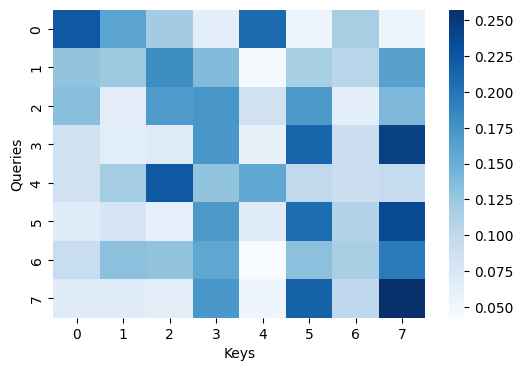

In [40]:
# Wizualizacja mapy atencji z pierwszej warstwy kodera Transformer dla pierwszej sekwencji ze wsadu
visualize_attention_map(attention_maps[0][0])

###Trenowanie modelu
Rozpoczęcie treningu modelu.

In [41]:
import os

CHECKPOINT_PATH = "saved_models/"

max_epochs = 3
lr = 5e-4
warmup = 50
max_iters = max_epochs*len(train_loader)

trainer = L.Trainer(max_epochs=2, log_every_n_steps=50)
trainer.fit(
    lit_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
    )

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping b

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

tensor([7, 8, 3, 0, 6, 0, 8, 0])
tensor([0, 8, 0, 6, 0, 3, 8, 7])
tensor([3, 8, 9, 4, 2, 3, 9, 7])
tensor([7, 9, 3, 2, 4, 9, 8, 3])
tensor([0, 1, 4, 8, 1, 5, 6, 7])
tensor([7, 6, 5, 1, 8, 4, 1, 0])
tensor([0, 7, 1, 9, 6, 5, 3, 1])
tensor([1, 3, 5, 6, 9, 1, 7, 0])
tensor([2, 8, 8, 8, 5, 0, 8, 2])
tensor([2, 8, 0, 5, 8, 8, 8, 2])
tensor([2, 4, 2, 5, 9, 2, 7, 3])
tensor([3, 7, 2, 9, 5, 2, 4, 2])
tensor([4, 2, 3, 6, 8, 7, 7, 0])
tensor([0, 7, 7, 8, 6, 3, 2, 4])
tensor([4, 6, 0, 3, 8, 7, 7, 6])
tensor([6, 7, 7, 8, 3, 0, 6, 4])
tensor([0, 7, 2, 8, 8, 4, 8, 7])
tensor([7, 8, 4, 8, 8, 2, 7, 0])
tensor([5, 5, 5, 7, 9, 5, 4, 8])
tensor([8, 4, 5, 9, 7, 5, 5, 5])
tensor([4, 4, 9, 3, 0, 6, 8, 9])
tensor([9, 8, 6, 0, 3, 9, 4, 4])
tensor([2, 6, 2, 5, 1, 7, 2, 7])
tensor([7, 2, 7, 1, 5, 2, 6, 2])
tensor([1, 4, 8, 5, 7, 7, 9, 6])
tensor([6, 9, 7, 7, 5, 8, 4, 1])
tensor([5, 2, 9, 7, 9, 9, 5, 3])
tensor([3, 5, 9, 9, 7, 9, 2, 5])
tensor([7, 0, 3, 5, 6, 9, 7, 4])
tensor([4, 7, 9, 6, 5, 3, 0, 7])
tensor([4,

Training: |          | 0/? [00:00<?, ?it/s]

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
tensor([6, 6, 8, 8, 5, 3, 6, 5])
tensor([5, 6, 3, 5, 8, 8, 6, 6])
tensor([8, 1, 6, 0, 6, 2, 2, 4])
tensor([4, 2, 2, 6, 0, 6, 1, 8])
tensor([1, 3, 4, 8, 5, 8, 3, 5])
tensor([5, 3, 8, 5, 8, 4, 3, 1])
tensor([9, 5, 1, 2, 6, 0, 0, 3])
tensor([3, 0, 0, 6, 2, 1, 5, 9])
tensor([1, 4, 3, 1, 5, 1, 4, 8])
tensor([8, 4, 1, 5, 1, 3, 4, 1])
tensor([8, 7, 8, 4, 0, 0, 1, 7])
tensor([7, 1, 0, 0, 4, 8, 7, 8])
tensor([6, 2, 0, 4, 8, 7, 9, 7])
tensor([7, 9, 7, 8, 4, 0, 2, 6])
tensor([2, 7, 6, 0, 0, 3, 5, 3])
tensor([3, 5, 3, 0, 0, 6, 7, 2])
tensor([5, 8, 3, 0, 6, 7, 4, 0])
tensor([0, 4, 7, 6, 0, 3, 8, 5])
tensor([1, 3, 1, 7, 2, 2, 9, 1])
tensor([1, 9, 2, 2, 7, 1, 3, 1])
tensor([9, 6, 8, 8, 9, 6, 7, 6])
tensor([6, 7, 6, 9, 8, 8, 6, 9])
tensor([1, 0, 7, 4, 8, 3, 9, 9])
tensor([9, 9, 3, 8, 4, 7, 0, 1])
tensor([4, 5, 7, 9, 4, 3, 8, 3])
tensor([3, 8, 3, 4, 9, 7, 5, 4])
tensor([7, 2, 8, 4, 2, 4, 1, 3])
tensor([3, 1, 4, 2, 4, 8, 2, 7])
tensor([4, 

Validation: |          | 0/? [00:00<?, ?it/s]

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
tensor([1, 1, 1, 4, 6, 9, 3, 6])
tensor([6, 3, 9, 6, 4, 1, 1, 1])
tensor([8, 3, 6, 1, 5, 9, 8, 9])
tensor([9, 8, 9, 5, 1, 6, 3, 8])
tensor([9, 3, 1, 7, 5, 4, 7, 6])
tensor([6, 7, 4, 5, 7, 1, 3, 9])
tensor([3, 7, 7, 0, 0, 2, 3, 5])
tensor([5, 3, 2, 0, 0, 7, 7, 3])
tensor([9, 8, 2, 5, 3, 4, 3, 4])
tensor([4, 3, 4, 3, 5, 2, 8, 9])
tensor([5, 3, 7, 1, 3, 5, 6, 8])
tensor([8, 6, 5, 3, 1, 7, 3, 5])
tensor([6, 9, 4, 1, 5, 0, 6, 3])
tensor([3, 6, 0, 5, 1, 4, 9, 6])
tensor([2, 7, 1, 2, 3, 6, 0, 7])
tensor([7, 0, 6, 3, 2, 1, 7, 2])
tensor([0, 1, 7, 3, 0, 5, 6, 5])
tensor([5, 6, 5, 0, 3, 7, 1, 0])
tensor([8, 1, 9, 0, 5, 2, 4, 6])
tensor([6, 4, 2, 5, 0, 9, 1, 8])
tensor([0, 1, 5, 8, 4, 3, 2, 2])
tensor([2, 2, 3, 4, 8, 5, 1, 0])
tensor([4, 5, 0, 6, 6, 8, 9, 4])
tensor([4, 9, 8, 6, 6, 0, 5, 4])
tensor([0, 1, 1, 9, 2, 4, 5, 1])
tensor([1, 5, 4, 2, 9, 1, 1, 0])
tensor([6, 6, 0, 4, 0, 7, 3, 9])
tensor([9, 3, 7, 0, 4, 0, 6, 6])
tensor([1, 

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([7, 8, 3, 0, 6, 0, 8, 0])
tensor([0, 8, 0, 6, 0, 3, 8, 7])
tensor([3, 8, 9, 4, 2, 3, 9, 7])
tensor([7, 9, 3, 2, 4, 9, 8, 3])
tensor([0, 1, 4, 8, 1, 5, 6, 7])
tensor([7, 6, 5, 1, 8, 4, 1, 0])
tensor([0, 7, 1, 9, 6, 5, 3, 1])
tensor([1, 3, 5, 6, 9, 1, 7, 0])
tensor([2, 8, 8, 8, 5, 0, 8, 2])
tensor([2, 8, 0, 5, 8, 8, 8, 2])
tensor([2, 4, 2, 5, 9, 2, 7, 3])
tensor([3, 7, 2, 9, 5, 2, 4, 2])
tensor([4, 2, 3, 6, 8, 7, 7, 0])
tensor([0, 7, 7, 8, 6, 3, 2, 4])
tensor([4, 6, 0, 3, 8, 7, 7, 6])
tensor([6, 7, 7, 8, 3, 0, 6, 4])
tensor([0, 7, 2, 8, 8, 4, 8, 7])
tensor([7, 8, 4, 8, 8, 2, 7, 0])
tensor([5, 5, 5, 7, 9, 5, 4, 8])
tensor([8, 4, 5, 9, 7, 5, 5, 5])
tensor([4, 4, 9, 3, 0, 6, 8, 9])
tensor([9, 8, 6, 0, 3, 9, 4, 4])
tensor([2, 6, 2, 5, 1, 7, 2, 7])
tensor([7, 2, 7, 1, 5, 2, 6, 2])
tensor([1, 4, 8, 5, 7, 7, 9, 6])
tensor([6, 9, 7, 7, 5, 8, 4, 1])
tensor([5, 2, 9, 7, 9, 9, 5, 3])
tensor([3, 5, 9, 9, 7, 9, 2, 5])
tensor([7, 0, 3, 5, 6, 9, 7, 4])
tensor([4, 7, 9, 6, 5, 3, 0, 7])
tensor([4,

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


tensor([3, 9, 4, 2, 7, 5, 4, 9])
tensor([9, 4, 5, 7, 2, 4, 9, 3])
tensor([5, 0, 9, 8, 0, 5, 5, 7])
tensor([7, 5, 5, 0, 8, 9, 0, 5])
tensor([9, 8, 8, 2, 5, 7, 3, 9])
tensor([9, 3, 7, 5, 2, 8, 8, 9])
tensor([1, 4, 3, 8, 5, 4, 2, 7])
tensor([7, 2, 4, 5, 8, 3, 4, 1])
tensor([8, 5, 0, 3, 1, 9, 4, 1])
tensor([1, 4, 9, 1, 3, 0, 5, 8])
tensor([4, 6, 3, 0, 1, 5, 0, 2])
tensor([2, 0, 5, 1, 0, 3, 6, 4])
tensor([7, 2, 2, 9, 6, 0, 5, 8])
tensor([8, 5, 0, 6, 9, 2, 2, 7])
tensor([7, 6, 2, 5, 4, 0, 2, 3])
tensor([3, 2, 0, 4, 5, 2, 6, 7])
tensor([7, 7, 8, 8, 3, 5, 9, 9])
tensor([9, 9, 5, 3, 8, 8, 7, 7])
tensor([2, 4, 5, 8, 1, 9, 3, 1])
tensor([1, 3, 9, 1, 8, 5, 4, 2])
tensor([2, 3, 3, 1, 7, 5, 5, 7])
tensor([7, 5, 5, 7, 1, 3, 3, 2])
tensor([1, 2, 3, 9, 8, 9, 4, 8])
tensor([8, 4, 9, 8, 9, 3, 2, 1])
tensor([9, 9, 0, 1, 0, 9, 2, 9])
tensor([9, 2, 9, 0, 1, 0, 9, 9])
tensor([9, 1, 1, 4, 2, 4, 9, 9])
tensor([9, 9, 4, 2, 4, 1, 1, 9])
tensor([7, 2, 6, 9, 7, 3, 0, 0])
tensor([0, 0, 3, 7, 9, 6, 2, 7])
tensor([1,

###Ewaluacja modelu
Ewaluacja wytrenowanego modelu na zbiorze testowym.

In [42]:
trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=1-step=780.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=1-step=780.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=1-step=780.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/l

Testing: |          | 0/? [00:00<?, ?it/s]

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
tensor([6, 9, 2, 3, 2, 4, 5, 1])
tensor([1, 5, 4, 2, 3, 2, 9, 6])
tensor([6, 1, 2, 2, 7, 5, 4, 2])
tensor([2, 4, 5, 7, 2, 2, 1, 6])
tensor([1, 5, 2, 7, 4, 9, 4, 2])
tensor([2, 4, 9, 4, 7, 2, 5, 1])
tensor([6, 6, 8, 4, 0, 0, 8, 8])
tensor([8, 8, 0, 0, 4, 8, 6, 6])
tensor([9, 0, 9, 6, 3, 9, 1, 7])
tensor([7, 1, 9, 3, 6, 9, 0, 9])
tensor([5, 6, 6, 6, 4, 1, 8, 1])
tensor([1, 8, 1, 4, 6, 6, 6, 5])
tensor([1, 9, 4, 8, 6, 8, 3, 0])
tensor([0, 3, 8, 6, 8, 4, 9, 1])
tensor([1, 9, 5, 1, 7, 8, 4, 4])
tensor([4, 4, 8, 7, 1, 5, 9, 1])
tensor([6, 4, 3, 8, 1, 2, 5, 9])
tensor([9, 5, 2, 1, 8, 3, 4, 6])
tensor([0, 8, 5, 0, 5, 1, 6, 4])
tensor([4, 6, 1, 5, 0, 5, 8, 0])
tensor([3, 5, 1, 0, 1, 2, 8, 6])
tensor([6, 8, 2, 1, 0, 1, 5, 3])
tensor([1, 7, 4, 8, 7, 7, 3, 4])
tensor([4, 3, 7, 7, 8, 4, 7, 1])
tensor([6, 9, 5, 2, 7, 4, 5, 7])
tensor([7, 5, 4, 7, 2, 5, 9, 6])
tensor([9, 6, 1, 3, 9, 5, 8, 9])
tensor([9, 8, 5, 9, 3, 1, 6, 9])
tensor([1, 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9999625086784363     │
└───────────────────────────┴───────────────────────────┘

[{'test/accuracy': 0.9999625086784363}]

Sprawdźmy wynik działania wytrenowanego modelu dla przykładowego wejścia.

In [43]:
batch = next(iter(test_loader))
inputs, targets = batch

print(inputs.shape)
print(targets.shape)

y = my_transformer.to(device)(inputs.cuda())
print(y.shape)

tensor([4, 6, 5, 7, 0, 2, 0, 7])
tensor([7, 0, 2, 0, 7, 5, 6, 4])
tensor([2, 2, 5, 6, 4, 1, 1, 4])
tensor([4, 1, 1, 4, 6, 5, 2, 2])
tensor([3, 3, 6, 8, 7, 9, 2, 5])
tensor([5, 2, 9, 7, 8, 6, 3, 3])
tensor([8, 2, 9, 0, 4, 9, 5, 9])
tensor([9, 5, 9, 4, 0, 9, 2, 8])
tensor([0, 3, 0, 1, 2, 1, 0, 9])
tensor([9, 0, 1, 2, 1, 0, 3, 0])
tensor([4, 8, 5, 5, 5, 5, 6, 9])
tensor([9, 6, 5, 5, 5, 5, 8, 4])
tensor([6, 0, 0, 1, 1, 1, 6, 6])
tensor([6, 6, 1, 1, 1, 0, 0, 6])
tensor([3, 1, 5, 8, 9, 6, 0, 4])
tensor([4, 0, 6, 9, 8, 5, 1, 3])
tensor([7, 2, 5, 2, 5, 5, 0, 7])
tensor([7, 0, 5, 5, 2, 5, 2, 7])
tensor([4, 6, 1, 4, 3, 3, 4, 2])
tensor([2, 4, 3, 3, 4, 1, 6, 4])
tensor([7, 5, 3, 1, 1, 3, 8, 1])
tensor([1, 8, 3, 1, 1, 3, 5, 7])
tensor([8, 4, 6, 3, 5, 4, 5, 3])
tensor([3, 5, 4, 5, 3, 6, 4, 8])
tensor([7, 8, 7, 6, 1, 1, 1, 5])
tensor([5, 1, 1, 1, 6, 7, 8, 7])
tensor([0, 6, 6, 7, 2, 6, 3, 1])
tensor([1, 3, 6, 2, 7, 6, 6, 0])
tensor([9, 3, 4, 8, 7, 3, 5, 5])
tensor([5, 5, 3, 7, 8, 4, 3, 9])
tensor([8,

In [44]:
for x, target, predicted in zip(inputs[0], targets[0], y[0]):
    print(f"Element z wejściowej sekwencji : {x}   Etykieta: {target}   Predykowana klasa: {predicted.detach().argmax(dim=0)}")

Element z wejściowej sekwencji : 4   Etykieta: 7   Predykowana klasa: 7
Element z wejściowej sekwencji : 6   Etykieta: 0   Predykowana klasa: 0
Element z wejściowej sekwencji : 5   Etykieta: 2   Predykowana klasa: 2
Element z wejściowej sekwencji : 7   Etykieta: 0   Predykowana klasa: 0
Element z wejściowej sekwencji : 0   Etykieta: 7   Predykowana klasa: 7
Element z wejściowej sekwencji : 2   Etykieta: 5   Predykowana klasa: 5
Element z wejściowej sekwencji : 0   Etykieta: 6   Predykowana klasa: 6
Element z wejściowej sekwencji : 7   Etykieta: 4   Predykowana klasa: 4


Wizualizacja mapy atencji dla przykładowego wejścia. Dla $i$-tego elementu w sekwencji model nauczył się zwracać uwagę na $i$-ty od końca element.
I o to chodziło, wyznaczając wartość $i$-tego elementu w odwróconej sekwencji należy wziąć wartość $i$-tego od końca elementu w wejściowej sekwencji.

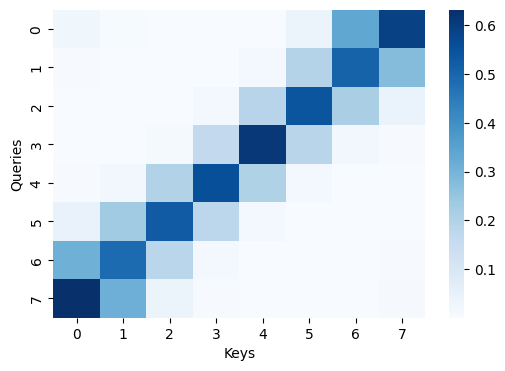

In [46]:
attention_maps = my_transformer.get_attention_maps(data_input.cuda())
# Odwołanie do map atencji z pierwszej warstwy dla pierwszej sekwencji ze wsadu
visualize_attention_map(attention_maps[0][0])

Zauważmy, że model nauczył się przekształcać sekwencje liczb poprzez demonstrację par złożonych z przykładowych sekwencji wejściowych i oczekiwanego wejścia.

##Zadanie: Zbalansowane nawiasy

Problem odwrócenia kolejności ciągu był bardzo prosty. Model nie musiał brać pod uwagę wartości elementów w sekwencji - wystarczyło, że nauczył się aby jako wartość $i$-tego elementu wyjścia brać $n-i$-ty element wejścia.

Spróbujmy trudniejszego problemu - sprawdzenia czy sekwencja nawiasów jest zbalansowana. Rozwiązanie tego problemy wymaga wzięcia pod uwagę zarówno pozycji elementów (nawiasów) jak i ich wartości (otwierający czy zamykający).

W odróżnieniu od poprzedniego problemu klasyfikujemy całą sekwencję - czy zawiera zrównoważone nawiasy czy nie. Czyli klasyfikator musimy oprzeć na wektorze reprezentującym całą sekwencję, a nie pojedyczy element.
Aby uzyskać **reprezentację o stałej długości dla całej sekwencji** można zastosować następujące podejścia:
- Na początku sekwencji dodać specjalny token `CLS` i kontekstową reprezentację tego tokenu traktować jak reprezentację całej sekwencji wejściowej. To podejście jest typowo stosowane w modelach klasy tylko-koder, np. BERT.
- Uśrednić kontekstowe reprezentacje wszystkich tokenów w sekwencji. W dalszej części notatnika zastosujemy to podejście.

###Zbiór danych

Pomocnicze funkcje tworzące zbiór danych złożony z napisów ze zbalansowanymi i nie zbalansowanymi nawiasami.

In [47]:
import random

def generate_balanced_brackets(n: int) -> list[str]:
    """Generate all balanced brackets string with n pairs."""
    result = []

    def backtrack(current, open_count, close_count):
        if len(current) == 2 * n:
            result.append(current)
            return

        if open_count < n:
            backtrack(current + "(", open_count + 1, close_count)
        if close_count < open_count:
            backtrack(current + ")", open_count, close_count + 1)

    backtrack("", 0, 0)
    return result

In [48]:
def generate_random_brackets(length) -> str:
    """Generate a random string of open or close brackets."""
    return "".join(random.choice(["(", ")"]) for _ in range(length))

In [49]:
def is_balanced(s: str) -> bool:
    """Check if a string of brackets is balanced."""
    balance = 0
    for char in s:
        if char == "(":
            balance += 1
        elif char == ")":
            balance -= 1
        if balance < 0:
            return False
    return balance == 0

In [50]:
class BracketDataset(Dataset):

    def __init__(self, num_pairs: int):
        super().__init__()
        self.num_pairs = num_pairs
        self.balanced_brackets = generate_balanced_brackets(num_pairs)

    def __len__(self):
        return len(self.balanced_brackets) * 2

    def __getitem__(self, idx):
        if idx % 2 == 0:
            s = self.balanced_brackets[idx // 2]
            label = 1
        else:
            s = generate_random_brackets(self.num_pairs*2)
            label = 0

        # Kodowanie: 0="(", 1=")"
        x = torch.tensor([0 if ch=="(" else 1 for ch in s])
        label = torch.tensor(label)
        return x, label

Przykładowe elementy ze zbioru danych - `0` oznacza nawias otwierający a `1` nawias zamykający. Etykieta `1` oznacza, że sekwencja nawiasów jest zbalansowana, a `0` przeciwnie.

In [51]:
ds = BracketDataset(num_pairs=10)
print(len(ds))
print(ds[0])
print(ds[1])
print(ds[2])
print(ds[3])
print(ds[4])

33592
(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor(1))
(tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]), tensor(0))
(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor(1))
(tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]), tensor(0))
(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]), tensor(1))


In [52]:
def decode_dataset_element(e):
    # Zdekoduj elementy zbioru danych
    x, label = e
    s = "".join(["(" if ch==0 else ")" for ch in x])
    s = f'{s}   {"balanced" if label==1 else "unbalanced"}'
    return s

In [53]:
print(decode_dataset_element(ds[0]))
print(decode_dataset_element(ds[1]))
print(decode_dataset_element(ds[2]))
print(decode_dataset_element(ds[3]))

(((((((((())))))))))   balanced
))(()(()))))))()())(   unbalanced
((((((((()()))))))))   balanced
((()()()))(())())))(   unbalanced


In [54]:
from torch.utils.data import random_split

train_size = int(0.8 * len(ds))
val_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - val_size

train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])

print(f"Rozmiar zbioru trningowego: {len(train_ds)}")
print(f"Rozmiar zbioru walidacyjnego: {len(val_ds)}")
print(f"Rozmiar zbioru testowego: {len(test_ds)}")

Rozmiar zbioru trningowego: 26873
Rozmiar zbioru walidacyjnego: 3359
Rozmiar zbioru testowego: 3360


In [55]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=128)
test_loader  = DataLoader(test_ds, batch_size=128)

###Definicja architektury modelu

Definicja modelu o architekturze Transformer klasy tylko-koder z liniową głowicą klasyfikującą sekwencję. Głowica klasyfikacyjna `self.classification` oparta jest o uśrednione kontekstowe reprezentacje elementów w sekwencji.

In [56]:
class MyTransformer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_classes: int, num_layers: int):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer = TransformerEncoder(num_layers, d_model, 2*d_model)
        self.classification = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)

        assert x.dim() == 3

        # Jako reprezentację całej sekwencji bierzemy uśrednione wektory reprezentacji
        x = x.mean(dim=1)
        x = self.classification(x)
        return x

    def get_attention_maps(self, x):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        with torch.no_grad():
            x = self.embeddings(x)
            x = self.positional_encoding(x)
            attention_maps = self.transformer.get_attention_maps(x)
        return attention_maps

In [57]:
class LitNet(L.LightningModule):
    def __init__(self, classifier: nn.Module):
        super().__init__()
        self.classifier = classifier
        self.criterion = nn.CrossEntropyLoss()

        # TODO: Change hard coded number of classes
        self.metric_train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2)
        self.metric_val_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2)
        self.metric_test_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=2)

    def training_step(self, batch, batch_idx):
        # training_step implementuje jeden krok pętli treningowej
        x, target = batch
        logits = self.classifier(x)
        loss = self.criterion(logits, target)
        self.log("train/loss", loss, prog_bar=True)

        _, preds = torch.max(logits, dim=1)
        self.metric_train_acc(preds, target)
        self.log('train/accuracy', self.metric_train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, target = batch
        logits = self.classifier(x)
        loss = self.criterion(logits, target)
        self.log("val/loss", loss, prog_bar=True)

        _, preds = torch.max(logits, dim=1)
        self.metric_val_acc(preds, target)
        self.log('val/accuracy', self.metric_val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, target = batch
        logits = self.classifier(x)

        _, preds = torch.max(logits, dim=1)
        self.metric_test_acc(preds, target)
        self.log('test/accuracy', self.metric_test_acc, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.classifier.parameters(), lr=1e-4, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=self.trainer.estimated_stepping_batches)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

Utworzenie instancji modelu sieci MyTransformer złożonej z jednej warstwy kodera Transformer (`num_layers=1`).

In [58]:
# Init the network
my_transformer = MyTransformer(vocab_size=2, d_model=32, num_classes=2, num_layers=1)
# Wrap in a lightning module
lit_model = LitNet(my_transformer)

###Trenowanie modelu

Uruchom trenowanie modelu.

In [59]:
import os

CHECKPOINT_PATH = "saved_models/"

max_epochs = 6
lr = 5e-4
warmup = 50
max_iters = max_epochs*len(train_loader)

#trainer = L.Trainer(max_epochs=num_epochs, logger=wandb_logger)
trainer = L.Trainer(max_epochs=2, log_every_n_steps=50)
trainer.fit(
    lit_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
    )

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping b

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


###Ewaluacja modelu

In [62]:
trainer.test(dataloaders=test_loader)

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=1-step=420.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=1-step=420.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=1-step=420.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=1-step=420.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.8690476417541504     │
└───────────────────────────┴───────────────────────────┘

[{'test/accuracy': 0.8690476417541504}]

Skuteczność klasyfikacji jest ograniczona (dokładność rzędu 87%), wytrenowany model nie jest w stanie poprawnie sprawdzić zbalansowania nawiasów dla każdej sekwencji wejściowej.

Wizualizacja mapy atencji dla przykładowego wejścia.

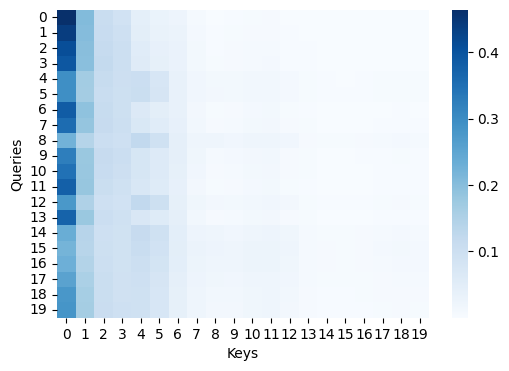

tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1])


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_input, labels = next(iter(val_loader))
#data_input = data_input.to(device)
attention_maps = my_transformer.get_attention_maps(data_input)

# Odwołanie do map atencji z dla pierwszej sekwencji ze wsadu
visualize_attention_map(attention_maps[0][0])
print(data_input[1])

Sprawdzimy czy większy model, złożony z trzech warstw kodera Transformer (`num_layers=3`) pozwoli osiągnąć lepsze wyniki.

In [67]:
# Init the network
my_transformer = MyTransformer(vocab_size=2, d_model=32, num_classes=2, num_layers=3)
# Wrap in a lightning module
lit_model = LitNet(my_transformer)

In [68]:
import os

CHECKPOINT_PATH = "saved_models/"

max_epochs = 6
lr = 5e-4
warmup = 50
max_iters = max_epochs*len(train_loader)

#trainer = L.Trainer(max_epochs=num_epochs, logger=wandb_logger)
trainer = L.Trainer(max_epochs=2, log_every_n_steps=50)
trainer.fit(
    lit_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
    )

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping b

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [69]:
trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=1-step=420.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=1-step=420.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_2/checkpoints/epoch=1-step=420.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/l

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9788690209388733     │
└───────────────────────────┴───────────────────────────┘

[{'test/accuracy': 0.9788690209388733}]

Zwiększenie liczy warstw kodera do trzech pozwoliło lepiej uchwycić zależności między elementami sekwencji. Skuteczność klasyfikacji na zbiorze testowym wzrosła z 87 do 97%.